# Aprendizado Não Supervisionado

Bibliotecas necessárias

In [1]:
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import os
import numpy as np
import matplotlib.pyplot as plt

---
## Funções auxiliares

### Função para obter a data anterior
Dado o ano, mês e o número de meses anteriores, retorna uma tupla (ano, mês) anterior ao número de meses.

In [2]:
def get_previous_date(year, month, n_months):
    years = n_months // 12
    n_months = n_months % 12
    year_result = year-years if month-n_months > 0 else year-(years+1)
    month_result = month-n_months if month-n_months > 0 else 12 if month-n_months == 0 else (month-n_months)%12
    return year_result, month_result

**Exemplo:** 3 meses anteriores a Fevereiro de 2019 é Novembro de 2018

In [3]:
get_previous_date(2019, 2, 3)

(2018, 11)

### Função para obter o caminho dos arquivos
Dado o ano, mês e o número de meses anteriores, retorna uma lista de caminhos dos arquivos dos meses anteriores.

In [4]:
def get_filepaths(year, month, n_months):
    filenames = []
    for n in range(n_months, -1, -1):
        y, m = get_previous_date(year, month, n)
        filenames.append('data/DadosBO_{0}_{1}(ROUBO DE CELULAR).xls'.format(y, m))
    return filenames

**Exemplo:** 3 meses anteriores a Fevereiro de 2019 deve retornar uma lista com os caminhos dos arquivos de:
* Novembro de 2018
* Dezembro de 2018
* Janeiro de 2019
* Fevereiro de 2019

In [5]:
get_filepaths(2019, 2, 3)

['data/DadosBO_2018_11(ROUBO DE CELULAR).xls',
 'data/DadosBO_2018_12(ROUBO DE CELULAR).xls',
 'data/DadosBO_2019_1(ROUBO DE CELULAR).xls',
 'data/DadosBO_2019_2(ROUBO DE CELULAR).xls']

### Função para carregar o *DataFrame*
Dado o caminho do arquivo e uma ordem para o mês (1o.mês, 2o.mês, etc), retorna um *DataFrame* com as colunas **Data da Ocorrência**, **Hora da Ocorrência**, **Bairro**, **Cidade**, **Latitude**, **Longitude** e a **Ordem do Mês**.

In [6]:
def load_dataframe(filepath, month):
    cols = ['DATAOCORRENCIA', 'HORAOCORRENCIA', 'BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE']
    df = pd.read_csv(
        filepath_or_buffer=filepath,
        encoding='utf-16 le',
        delimiter='\t',
        decimal=',',
        dayfirst=True,
        usecols=cols
    )
    df['MES'] = month
    return df

**Exemplo:** Carregando os dados de Fevereiro de 2019, definindo a ordem deste *DataFrame* como o primeiro:

In [7]:
load_dataframe('data/DadosBO_2019_2(ROUBO DE CELULAR).xls', 1)

,DATAOCORRENCIA,HORAOCORRENCIA,BAIRRO,CIDADE,LATITUDE,LONGITUDE,MES
0,31/01/2019,19:00,ITAIM PAULISTA,S.PAULO,-23.510144,-46.397749,1
1,31/01/2019,21:45,VALO VELHO,ITAPECERICA DA SERRA,-23.689874,-46.800888,1
2,31/01/2019,16:20,CAETETUBA,ATIBAIA,-23.114819,-46.586959,1
3,31/01/2019,16:20,CAETETUBA,ATIBAIA,-23.114819,-46.586959,1
4,28/01/2019,04:30,ITAIM PAULISTA,S.PAULO,-23.497685,-46.393311,1
...,...,...,...,...,...,...,...
20811,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,1
20812,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,1
20813,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,1
20814,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,1


### Função para carregar e concatenar vários *DataFrames*
Dado o ano, mês e o número de meses anteriores, retorna um *DataFrame* com os dados dos meses anteriores e o atual, em ordem cronológica

In [8]:
def load_dataframes(year, month, n_months):
    filepaths = get_filepaths(year, month, n_months)
    return pd.concat([load_dataframe(filepath, idx + 1) for idx, filepath in enumerate(filepaths)])

**Exemplo:** 3 meses anteriores a Fevereiro de 2019 retorna um *DataFrame* com os dados de:
* Novembro de 2018 como o primeiro mês
* Dezembro de 2018 como o segundo mês
* Janeiro de 2019 como o terceiro mês
* Fevereiro de 2019 como o quarto mês

In [9]:
load_dataframes(2019, 2, 3)

,DATAOCORRENCIA,HORAOCORRENCIA,BAIRRO,CIDADE,LATITUDE,LONGITUDE,MES
0,31/10/2018,06:25,NaN,S.PAULO,NaN,NaN,1
1,31/10/2018,21:30,JD IRMÃOS SIGRIST,CAMPINAS,-23.003776,-47.106153,1
2,31/10/2018,20:30,NOVA BAETA,S.BERNARDO DO CAMPO,NaN,NaN,1
3,31/10/2018,20:30,NaN,PRAIA GRANDE,-24.042856,-46.507023,1
4,31/10/2018,21:00,JD ARARUAMA,COTIA,-23.609402,-46.929926,1
...,...,...,...,...,...,...,...
20811,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,4
20812,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,4
20813,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,4
20814,28/02/2019,20:00,JAGUARE,S.PAULO,-23.548775,-46.732606,4


### Função para limpar o *DataFrame*
Dado o *DataFrame*, retorna o *DataFrame* sem entradas duplicadas ou com valores nulos

In [10]:
def clear_dataframe(df):
    df.drop_duplicates(inplace=True)
    df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
    df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')
    df.dropna(inplace=True)
    return df

In [11]:
df = load_dataframes(2019, 2, 3)
clear_dataframe(df)

,DATAOCORRENCIA,HORAOCORRENCIA,BAIRRO,CIDADE,LATITUDE,LONGITUDE,MES
1,31/10/2018,21:30,JD IRMÃOS SIGRIST,CAMPINAS,-23.003776,-47.106153,1
4,31/10/2018,21:00,JD ARARUAMA,COTIA,-23.609402,-46.929926,1
5,31/10/2018,23:00,SAO LUCAS,S.PAULO,-23.576057,-46.554417,1
6,31/10/2018,23:00,SAO RAFAEL,S.PAULO,-23.630611,-46.471524,1
7,31/10/2018,23:40,BRASILANDIA,S.PAULO,-23.457706,-46.690668,1
...,...,...,...,...,...,...,...
20807,28/02/2019,20:45,GUAIANASES,S.PAULO,-23.542405,-46.419923,4
20808,28/02/2019,19:00,SANTO AMARO,S.PAULO,-23.628584,-46.691692,4
20809,28/02/2019,16:00,VILA SONIA,S.PAULO,-23.595742,-46.740399,4
20810,28/02/2019,22:40,VILA HELENA II,SUZANO,-23.597856,-46.307167,4


### Função para obter a posição de inicialização dos *centroids* e o número de agrupamentos
Dado o *DataFrame*, a função calcula a posição inicial dos *centroids* a partir da localização geográfica média de todos os eventos ocorridos em cada bairro de cada cidade e retorna uma tupla com as posições iniciais dos *centroids* e o número de agrupamentos.

In [12]:
def get_init_clusters_info(df):
    init_clusters = df[['BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE']].groupby(['CIDADE', 'BAIRRO']).mean().dropna().to_numpy()
    n_clusters, _ = init_clusters.shape
    return init_clusters, n_clusters

In [13]:
df = load_dataframes(2019, 2, 3)
df = clear_dataframe(df)
init_clusters, n_clusters = get_init_clusters_info(df)

In [14]:
init_clusters

array([[-23.54442   , -46.6547956 ],
       [-23.0976156 , -47.0078479 ],
       [-23.6383081 , -46.7929286 ],
       ...,
       [-20.42796844, -49.97685624],
       [-20.42519928, -49.96072917],
       [-20.38642429, -49.98031964]])

In [15]:
n_clusters

5962

### Função para treinar modelo de agrupamento *K-Means*
Dado o ano, mês e o número de meses anteriores, carrega *DataFrames* de treino e teste, cria e treina o modelo de agrupamento *K-Means* a partir dos dados de treino e assimila todas as amostras a seus respectivos grupos. Os *DataFrames* com os dados dos grupos são salvos no disco.

In [16]:
def train_cluster_model(year, month, n_months):
    dirname = 'df'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    df = load_dataframes(year, month, n_months)
    df = clear_dataframe(df)
    
    train = df['MES'] != n_months+1
    df_train = df[train].copy()
    df_test = df[~train].copy()
    
    init_clusters, n_clusters = get_init_clusters_info(df_train)
    kmeans = MiniBatchKMeans(init=init_clusters, n_clusters=n_clusters, init_size=n_clusters, max_iter=100000, n_init=1, random_state=42)
    
    df_train['GRUPO'] = kmeans.fit_predict(df_train[['LATITUDE', 'LONGITUDE']])
    df_test['GRUPO'] = kmeans.predict(df_test[['LATITUDE', 'LONGITUDE']])
    
    df_train.to_pickle('{0}/{1}_{2}_{3}_train.pkl'.format(dirname, year, month, n_months))
    df_test.to_pickle('{0}/{1}_{2}_{3}_test.pkl'.format(dirname, year, month, n_months))
    return n_clusters

---
## Treinamento
Treinamento do modelo de agrupamentos *K-Means* é realizado:
* para cada mês de 2019
* de 1 a 12 meses anteriores para treinamento

In [17]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_clusters = np.zeros((len(months), len(n_months)))

for month in months:
    for n_month in n_months:
            n_clusters[month-1][n_month-1] = train_cluster_model(2019, month, n_month)

---
### Número médio de agrupamentos

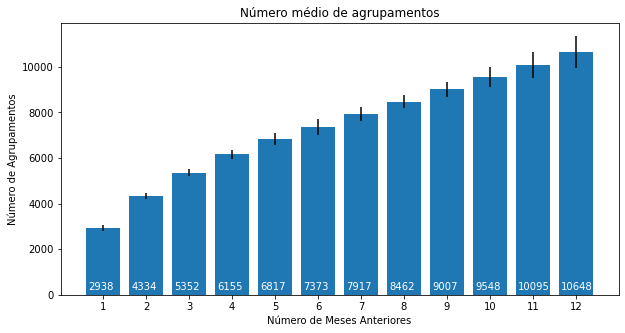

In [18]:
clusters_mean = np.mean(n_clusters, axis=0, dtype=int)
clusters_std = np.std(n_clusters, axis=0)
n_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
plt.figure(figsize=(10, 5))
plt.bar(x=n_months, height=clusters_mean, yerr=clusters_std)
for i, v in enumerate(clusters_mean):
    plt.text(n_months[i] - 0.35, 200, str(v), color='white')
plt.xticks(n_months)
plt.title('Número médio de agrupamentos')
plt.xlabel('Número de Meses Anteriores')
plt.ylabel('Número de Agrupamentos')
plt.savefig('figures/n_clusters.png', dpi=300)
plt.show()